In [1]:
from pytorch_lightning.utilities import grad_norm
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import torch.optim as optim
from braingeneers.analysis import SpikeData
import os
import json
import pytorch_lightning as pl
from backbones import ResNet18Enc, ResNet18Dec
import wandb
import pickle
from tqdm import tqdm
import scanpy as sc 
import matplotlib.pyplot as plt 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import anndata as an 
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
import umap
from collections import Counter
import pandas as pd

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
#Read ACQM files
import numpy as np
from braingeneers import analysis
import zipfile

def load_curation(qm_path):
    with zipfile.ZipFile(qm_path, 'r') as f_zip:
        qm = f_zip.open("qm.npz")
        data = np.load(qm, allow_pickle=True)
        spike_times = data["train"].item()
        fs = data["fs"]
        train = [times / fs for _, times in spike_times.items()]
        if "config" in data:
            config = data["config"].item()
        else:
            config = None
        neuron_data = data["neuron_data"].item()
    return train, neuron_data, config, fs

qm_path1 = "/Users/jesusgf/Desktop/ephys_autoencoder/1d-constrastive-autoencoder/unlabeled_data_templates/ephys/2024-04-04-e-p001384-pharma-reupload/derived/kilosort2/Trace_20240404_17_27_54_day26_p001384_baseline_528pm_acqm.zip"
#qm_path1 = "/Users/jesusgf/Desktop/ephys_autoencoder/1d-constrastive-autoencoder/unlabeled_data_templates/ephys/2024-04-04-e-p001384-pharma-reupload/derived/kilosort2/Trace_20240405_08_15_06_day27_001384_baseline_815am_acqm.zip"
#qm_path1 = "/Users/jesusgf/Desktop/ephys_autoencoder/1d-constrastive-autoencoder/unlabeled_data_templates/ephys/2024-04-04-e-p001384-pharma-reupload/derived/kilosort2/Trace_20240405_10_00_51_day27_p001384_baseline_1001am_acqm.zip"
train1, neuron_data1, _, fs1 = load_curation(qm_path1)
sd1 = analysis.SpikeData(train1, neuron_data={0: neuron_data1})
print("Units train1",len(train1))

qm_path2 = "/Users/jesusgf/Desktop/ephys_autoencoder/1d-constrastive-autoencoder/unlabeled_data_templates/ephys/2024-04-04-e-p001384-pharma-reupload/derived/kilosort2/Trace_20240404_17_40_05_day26_p001384_APV_540pm_acqm.zip"
#qm_path2 = "/Users/jesusgf/Desktop/ephys_autoencoder/1d-constrastive-autoencoder/unlabeled_data_templates/ephys/2024-04-04-e-p001384-pharma-reupload/derived/kilosort2/Trace_20240405_08_25_32_day27_p001384_bicuculline_827am_acqm.zip"
#qm_path2 = "/Users/jesusgf/Desktop/ephys_autoencoder/1d-constrastive-autoencoder/unlabeled_data_templates/ephys/2024-04-04-e-p001384-pharma-reupload/derived/kilosort2/Trace_20240405_10_12_27_day2_p001384_dmso_1012am_acqm.zip"
train2, neuron_data2, _, fs2 = load_curation(qm_path2)
print("Units train2",len(train2))
sd2 = analysis.SpikeData(train2, neuron_data={0: neuron_data2})


Units train1 24
Units train2 21


In [3]:
# for k, v in neuron_data1.items():
#     print(k, v.keys())

# for k, v in neuron_data2.items():
#     print(k, v.keys())

neuron_data1[0].keys()


dict_keys(['cluster_id', 'channel', 'position', 'template', 'amplitudes', 'waveforms', 'neighbor_channels', 'neighbor_positions', 'neighbor_templates'])

In [4]:
isi_1 = sd1.interspike_intervals()
waveforms1 = [neuron_data1[i]["waveforms"] for i in range(len(neuron_data1))]
isi_dist1 = []
bad_indices = []
for idx, isi in enumerate(isi_1):
    hist, _ = np.histogram(isi[isi < 100], bins=100) #This is in miliseconds# Tal had (bin widths were set to 1/15th of the median ISI for a given unit)
    #Convert the counts to percentage
    
    hist = hist/sum(hist)
    if not np.isnan(hist).all():
        isi_dist1.append(hist)
    else:
        bad_indices.append(idx)
waveforms1 = [waveforms1[i] for i in range(len(waveforms1)) if i not in bad_indices]

In [5]:
isi_distribution = pd.DataFrame(isi_dist1)

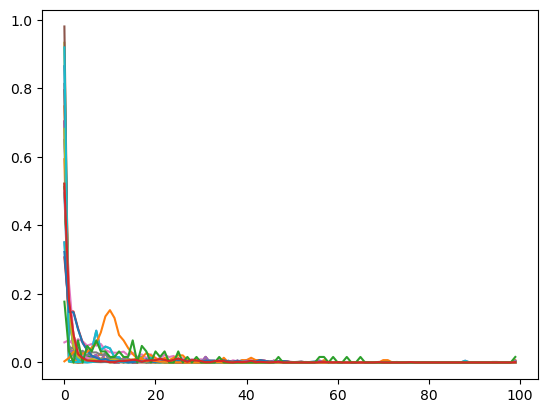

In [10]:
isi_distribution
#Plot the ISI distribution
for row in isi_distribution.iterrows():
    plt.plot(row[1])

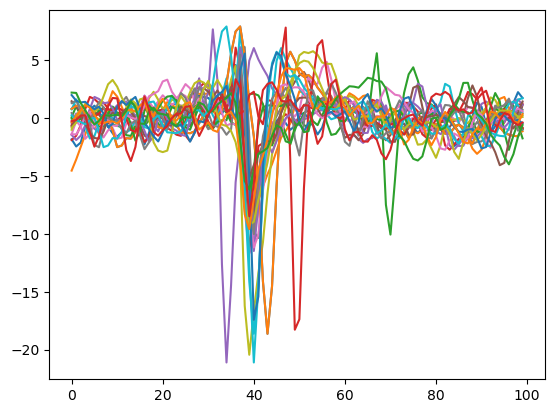

In [94]:
waveforms1[0][0]
#Plot the waveform of the first neuron. I have to cut them first to 50 datapoints
for i in range(len(waveforms1)):
    plt.plot(waveforms1[i][0])

plt.show()


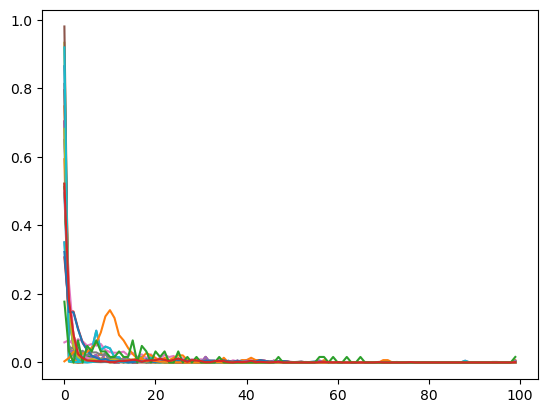

In [95]:
#Plot isi distribution for all neurons
for i in range(len(isi_dist1)):
    plt.plot(isi_dist1[i])

In [96]:
#Get 20 points before and 30 after the smallest value for the waveform
#Cut dataset
waveforms1_cut = []
min_waveform = [min(waveforms1[i][0]) for i in range(len(waveforms1))]
for i in range(len(waveforms1)):
    min_idx = np.argmin(waveforms1[i][0])
    #plt.plot(waveforms1[i][0][min_idx-20:min_idx+30])
    waveforms1_cut.append(waveforms1[i][0][min_idx-20:min_idx+30])


In [97]:
from scipy.interpolate import interp1d
for i in range(len(waveforms1_cut)):
    #plt.plot(waveforms1_cut[i])
    print(len(waveforms1_cut[i]))

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


In [98]:
#Normalize the data
min_val = np.min(waveforms1_cut)
max_val = np.max(waveforms1_cut)
waveforms1_cut = (waveforms1_cut - min_val) / (max_val - min_val)
# Scale to range [-1, 1]
waveforms1_cut = waveforms1_cut * 2 - 1
#waveforms = (waveforms - waveforms.mean()) / waveforms.std()
#0 1 normalization
#waveforms = (waveforms - waveforms.min()) / (waveforms.max() - waveforms.min())
isi_dist1 = np.array(isi_dist1)
isi_dists1 = isi_dist1 / isi_dist1.sum(axis=1, keepdims=True)

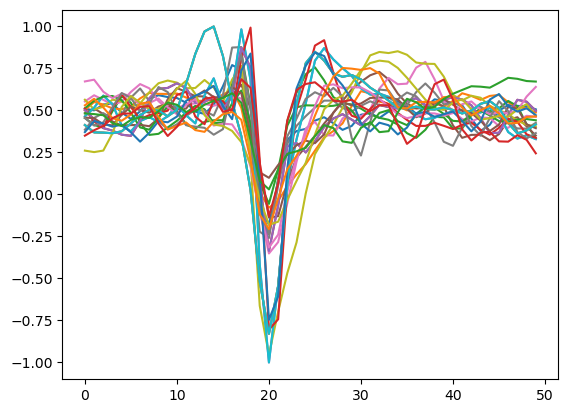

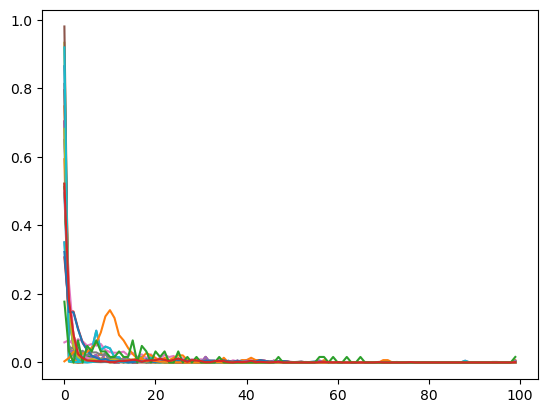

In [99]:
#Plot the cut waveforms
for i in range(len(waveforms1_cut)):
    plt.plot(waveforms1_cut[i])
plt.show()
#Plot the isi distribution
for i in range(len(isi_dists1)):
    plt.plot(isi_dists1[i])

In [100]:
isi_2 = sd2.interspike_intervals()
waveforms2 = [neuron_data2[i]["waveforms"] for i in range(len(neuron_data2))]
isi_dist2 = []
bad_indices = []
for idx, isi in enumerate(isi_2):
    hist, _ = np.histogram(isi[isi < 100], bins=100) #This is in miliseconds# Tal had (bin widths were set to 1/15th of the median ISI for a given unit)
    #Convert the counts to percentage
    
    hist = hist/sum(hist)
    if not np.isnan(hist).all():
        isi_dist2.append(hist)
    else:
        bad_indices.append(idx)
waveforms2 = [waveforms2[i] for i in range(len(waveforms2)) if i not in bad_indices]
waveforms2_cut = []
min_waveform = [min(waveforms2[i][0]) for i in range(len(waveforms2))]
for i in range(len(waveforms2)):
    min_idx = np.argmin(waveforms2[i][0])
    #plt.plot(waveforms1[i][0][min_idx-20:min_idx+30])
    waveforms2_cut.append(waveforms2[i][0][min_idx-20:min_idx+30])

min_val = np.min(waveforms2_cut)
max_val = np.max(waveforms2_cut)
waveforms2_cut = (waveforms2_cut - min_val) / (max_val - min_val)
# Scale to range [-1, 1]
waveforms2_cut = waveforms2_cut * 2 - 1
#waveforms = (waveforms - waveforms.mean()) / waveforms.std()
#0 1 normalization
#waveforms = (waveforms - waveforms.min()) / (waveforms.max() - waveforms.min())
isi_dist2 = np.array(isi_dist2)
isi_dists2 = isi_dist2 / isi_dist2.sum(axis=1, keepdims=True)

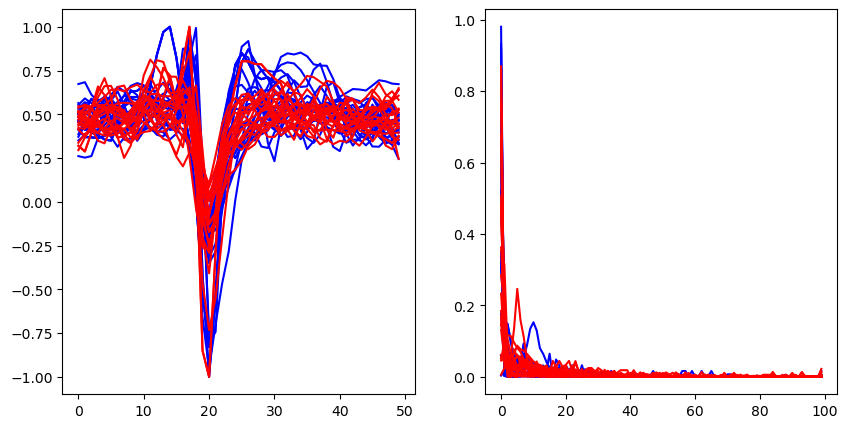

In [101]:
#Plot the cut waveforms
figsize = (10, 5)
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i in range(len(waveforms1_cut)):
    ax[0].plot(waveforms1_cut[i], color="blue")
for i in range(len(waveforms2_cut)):
    ax[0].plot(waveforms2_cut[i], color="red")
#Plot the isi distribution
for i in range(len(isi_dists1)):
    ax[1].plot(isi_dists1[i], color="blue")
for i in range(len(isi_dists2)):
    ax[1].plot(isi_dists2[i], color="red")


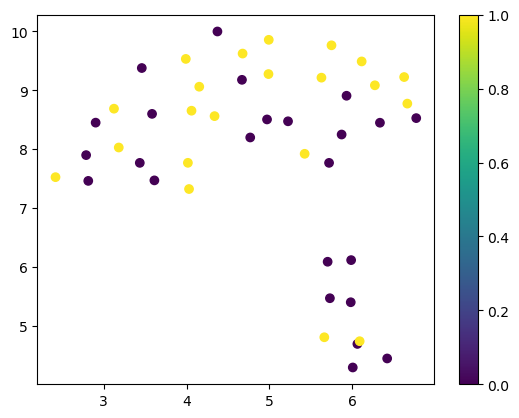

In [102]:
#UMAP the data
waveforms1_cut = np.array(waveforms1_cut)
waveforms2_cut = np.array(waveforms2_cut)

waveforms = np.concatenate([waveforms1_cut, waveforms2_cut], axis=0)
isi_dists = np.concatenate([isi_dists1, isi_dists2], axis=0)
#Batch 
labels1 = np.zeros(len(waveforms1_cut))
labels2 = np.ones(len(waveforms2_cut))

umap_model = umap.UMAP(n_components=2)
umap_data = umap_model.fit_transform(waveforms)
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=np.concatenate([labels1, labels2]))
plt.colorbar()
plt.show()


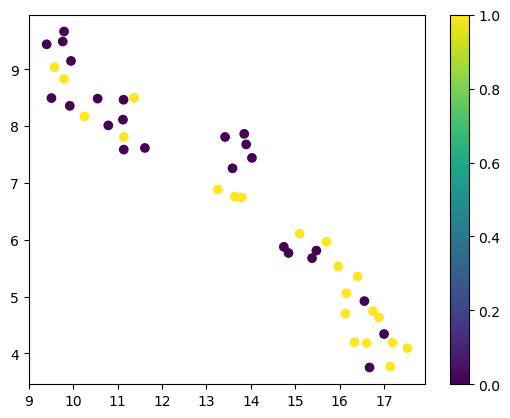

In [103]:
umap_model = umap.UMAP(n_components=2)
umap_data = umap_model.fit_transform(isi_dists)
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=np.concatenate([labels1, labels2]))
plt.colorbar()
plt.show()
